In [1]:
%run _common.ipynb

Cuda available: True


In [2]:
from src import model_data as md
from matplotlib import pylab as plt
import pandas as pd

In [3]:
pipeline = md.MultiTickerPipeline(
    target="return",
    target_type="single",
    model_seq_len=30,
    max_overlap=20,
    train_periods=[
        ("2012-01-01", "2019-12-31"),
    ],
    test_periods=[
        ("2020-01-01", "2021-04-01"),
    ],
    normalization_method="log",
    cross_validation_folds=5
)

In [4]:
pipeline.load_data('return-single-96tickers')

INFO:src.model_data:Loading generated data from /home/rluo/raid/classes/gatech/cs7643/GATech-CS7643-Project-Group/data/model_data/return-single-96tickers...
INFO:src.model_data:  Loading train folds...
INFO:src.model_data:  Loading test arrays...


In [5]:
price_pipeline = md.MultiTickerPipeline()
price_pipeline.load_data('price-single-96tickers')

INFO:src.model_data:Loading generated data from /home/rluo/raid/classes/gatech/cs7643/GATech-CS7643-Project-Group/data/model_data/price-single-96tickers...
INFO:src.model_data:  Loading train folds...
INFO:src.model_data:  Loading test arrays...


In [9]:
train_data = pipeline._train_out
test_data = pipeline._test_out

In [10]:
fold5 = train_data[4]
train = fold5['train']
valid = fold5['valid']

In [11]:
device = "cuda:2"

In [12]:
# x_train, y_train = torch.from_numpy(train['x']).to(device), torch.from_numpy(train['y']).to(device)
x_valid, y_valid = torch.from_numpy(valid['x'].astype("float32")).to(device), torch.from_numpy(valid['y'].astype("float32")).to(device)
x_test, y_test = torch.from_numpy(test_data['x'].astype("float32")).to(device), torch.from_numpy(test_data['y'].astype("float32")).to(device)

In [13]:
class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, datadict):
        self.x = datadict['x'].astype("float32")
        self.y = datadict['y'].astype("float32")
        
    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [14]:
class SeqModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        #
        self.lstm = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.lstm(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out


In [15]:
input_dim = x_valid.shape[2]
output_dim = y_valid.shape[1]

In [16]:
hidden_dim = 128
num_layers = 2
num_epochs = 400
learning_rate = 0.001

In [17]:
data_loader_params = {
    "batch_size": 64,
    "shuffle": True,
    "num_workers": 10
}

In [18]:
train_set = SeqDataset(train)

In [19]:
train_loader = torch.utils.data.DataLoader(train_set, **data_loader_params)

In [20]:
model = SeqModel(input_dim, hidden_dim, num_layers, output_dim).to(device)

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
criterion = nn.L1Loss(reduction='mean')

In [23]:
num_epochs = 400
early_stopping_epochs = 10

In [24]:
train_hist = []
valid_hist = []
min_observed_valid_loss = np.inf

for epoch in range(num_epochs):
    train_loss_per_batch = []
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        model.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        
        loss.backward()
        optimizer.step()
        train_loss_per_batch.append(loss.item())
        del x, y
        torch.cuda.empty_cache()
    train_loss_epoch = np.mean(train_loss_per_batch)
    
    with torch.no_grad():
        y_valid_pred = model(x_valid)
        valid_loss_epoch = criterion(y_valid_pred, y_valid)
        del y_valid_pred
        torch.cuda.empty_cache()

    min_observed_valid_loss = min(min_observed_valid_loss, valid_loss_epoch)
    
    train_hist.append(train_loss_epoch)
    valid_hist.append(valid_loss_epoch)
    
    print(f"Epoch {epoch}, train loss: {train_loss_epoch:.4f}, validation loss: {valid_loss_epoch:.4f}")
    
    if epoch > early_stopping_epochs:
        if min_observed_valid_loss < min(valid_hist[-10:]):
            print(f"Validation loss not improved in the last {early_stopping_epochs} epochs, breaking...")
            break

y_test_pred = model(x_test)
test_loss = criterion(y_test_pred, y_test)
print(f"test loss: {test_loss:.4f}")

Epoch 0, train loss: 0.0299, validation loss: 0.0148
Epoch 1, train loss: 0.0158, validation loss: 0.0150
Epoch 2, train loss: 0.0146, validation loss: 0.0234
Epoch 3, train loss: 0.0138, validation loss: 0.0193
Epoch 4, train loss: 0.0139, validation loss: 0.0192
Epoch 5, train loss: 0.0139, validation loss: 0.0170
Epoch 6, train loss: 0.0128, validation loss: 0.0155
Epoch 7, train loss: 0.0128, validation loss: 0.0145
Epoch 8, train loss: 0.0128, validation loss: 0.0152
Epoch 9, train loss: 0.0128, validation loss: 0.0155
Epoch 10, train loss: 0.0129, validation loss: 0.0138
Epoch 11, train loss: 0.0128, validation loss: 0.0140
Epoch 12, train loss: 0.0126, validation loss: 0.0137
Epoch 13, train loss: 0.0126, validation loss: 0.0146
Epoch 14, train loss: 0.0124, validation loss: 0.0137
Epoch 15, train loss: 0.0124, validation loss: 0.0137
Epoch 16, train loss: 0.0126, validation loss: 0.0139
Epoch 17, train loss: 0.0126, validation loss: 0.0155
Epoch 18, train loss: 0.0123, validati

In [104]:
ticker = "MSFT"

In [105]:
ticker_ind = np.argwhere(test_data['ticker'] == ticker).squeeze()

In [106]:
ticker_ypred = y_test_pred.cpu().detach().numpy()[ticker_ind, :]
ticker_y = y_test.cpu().detach().numpy()[ticker_ind, :]
ticker_dates = test_data['prediction_date'][ticker_ind]

In [107]:
ticker_price_pred = (
    price_pipeline._test_out['x'].astype("float32")[ticker_ind, -1, 0].reshape(-1, 1) * 
    (1 + ticker_ypred)
)
ticker_price = price_pipeline._test_out['y'].astype("float32")[ticker_ind, :]

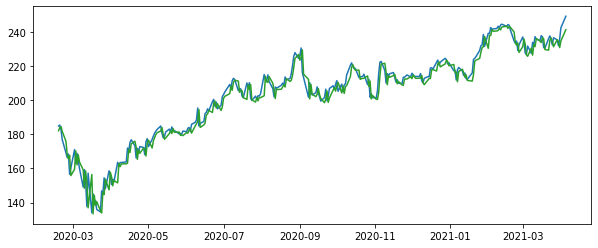

In [111]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(pd.to_datetime(ticker_dates), ticker_price)
ax.plot(pd.to_datetime(ticker_dates), ticker_price_pred, color="C2")

In [109]:
np.abs(ticker_price_pred - ticker_price).mean()

3.6405084

In [101]:
y_valid_pred = model(x_valid)

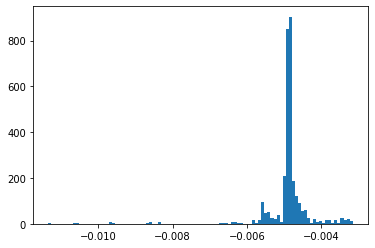

In [102]:
_ = plt.hist(y_valid_pred.cpu().detach().numpy(), bins=100)

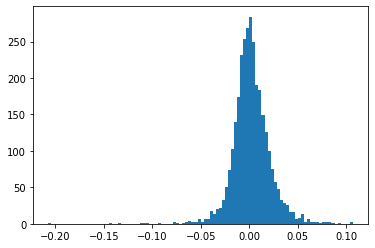

In [103]:
_ = plt.hist(y_valid.cpu().detach().numpy(), bins=100)

In [70]:
all_test_pred = (
    price_pipeline._test_out['x'].astype("float32")[:, -1, 0].reshape(-1, 1) * 
    (1 + y_test_pred.cpu().detach().numpy())
)

In [76]:
price_pipeline._test_out['y'].astype("float32").shape

(27360, 1)

In [73]:
all_test_pred.shape

(27360, 1)

In [74]:
test_data['prediction_date'].shape

(27360,)

In [75]:
test_data['ticker'].shape

(27360,)

In [77]:
test_pred_df = pd.DataFrame(
    {
        "y_pred": all_test_pred.squeeze(),
        "y": price_pipeline._test_out['y'].astype("float32").squeeze(),
        "date": test_data['prediction_date'],
        "ticker": test_data['ticker']
    }
)

In [85]:
test_pred_pivot = test_pred_df[['y_pred', "date", "ticker"]].pivot(values="y_pred", columns="ticker", index="date")
test_actual_pivot = test_pred_df[['y', "date", "ticker"]].pivot(values="y", columns="ticker", index="date")

In [86]:
test_pred_pivot.to_csv("../outputs/predicted_price_gru_model_with_return.csv")
test_actual_pivot.to_csv("../outputs/actual_price_gru_model_with_return.csv")

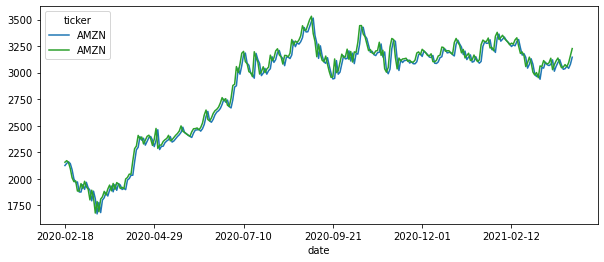

In [92]:
fig, ax = plt.subplots(figsize=(10, 4))
test_pred_pivot[['AMZN']].plot(ax=ax)
test_actual_pivot[['AMZN']].plot(ax=ax, color="C2")